# 构建投资组合

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import datetime

from pathlib import Path
import sys
import os
root_dir = str(Path(os.getcwd()).parent)
sys.path.append(root_dir)

from report.evaluate.protfolio import get_protfolio_net_value, max_dd

import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei']

## 每季度完成一次投资统计净值变化

In [2]:
index_data = pq.read_table(f'{root_dir}/data/intermediate_results/index_data.parquet').to_pandas()
index_data = index_data.loc[index_data['stock_symbol']=='000001']
index_data['quarter'] = pd.to_datetime(index_data['trade_date']).dt.to_period('Q')
index_data = index_data.loc[index_data['quarter'] >= '2007Q1']
index_data = index_data.sort_values(by='trade_date').reset_index(drop=True)
index_data['rets'] = index_data['rets'] + 1
index_data['net_values'] = index_data['rets'].cumprod()
index_rets = index_data.groupby('quarter').last().reset_index()
index_rets

,quarter,stock_symbol,trade_date,close,rets,net_values
0,2007Q1,000001,2007-03-30,3183.983,0.995761,1.190061
1,2007Q2,000001,2007-06-29,3820.703,0.976112,1.428040
2,2007Q3,000001,2007-09-28,5552.301,1.026417,2.075254
3,2007Q4,000001,2007-12-28,5261.563,0.991086,1.966587
4,2008Q1,000001,2008-03-31,3472.713,0.969992,1.297980
...,...,...,...,...,...,...
67,2023Q4,000001,2023-12-29,2974.935,1.006847,1.130368
68,2024Q1,000001,2024-03-29,3041.167,1.010132,1.155537
69,2024Q2,000001,2024-06-28,2967.403,1.007316,1.127508
70,2024Q3,000001,2024-09-30,3336.497,1.080637,1.267749


In [3]:
return_data = pq.read_table(f'{root_dir}/data/intermediate_results/return_data.parquet').to_pandas()
return_data = return_data.loc[return_data['trade_date'] >= datetime.date(2006,12,31), ['stock_symbol', 'trade_date', 'state', 'close']]
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
return_data = pd.merge(left=trade_date_lag, right=return_data, on=['stock_symbol', 'trade_date'], how='left')

stk_info = pq.read_table(f'{root_dir}/data/intermediate_results/stk_info.parquet').to_pandas()[['stock_symbol', 'listed_date']]
trade_date_lag = pq.read_table(f'{root_dir}/data/intermediate_results/trade_date_lag.parquet').to_pandas()
yysj_pro = pq.read_table(f'{root_dir}/data/intermediate_results/yysj_pro.parquet').to_pandas()[['stock_symbol', 'report_type', 'book_time_rank_first', 'book_time_rank_last', 'days_to_deadline']]

protfolio = pd.merge(left=yysj_pro, right=stk_info, how='left')
protfolio = pd.merge(left=return_data, right=protfolio, on=['stock_symbol', 'report_type'], how='left')
protfolio['report_type'] = pd.to_datetime(protfolio['report_type']).dt.to_period('Q') + 1
protfolio

,stock_symbol,report_type,trade_date,lag,state,close,book_time_rank_first,book_time_rank_last,days_to_deadline,listed_date
0,000001,2007Q1,2007-02-01,-30,NaN,NaN,0.280000,0.280000,39.0,1991-04-03
1,000002,2007Q1,2007-01-30,-30,1.0,16.90,0.247843,0.247843,41.0,1991-01-29
2,000004,2007Q1,2007-03-16,-30,NaN,NaN,0.873725,0.873725,3.0,1991-01-14
3,000006,2007Q1,2007-02-05,-30,1.0,11.32,0.309804,0.309804,37.0,1992-04-27
4,000007,2007Q1,2007-03-09,-30,1.0,4.22,0.734118,0.734118,10.0,1992-04-13
...,...,...,...,...,...,...,...,...,...,...
12782728,688799,2024Q4,2024-12-10,30,1.0,41.08,0.355142,0.350833,2.0,2021-07-13
12782729,688800,2024Q4,2024-12-06,30,1.0,42.11,0.100686,0.100881,6.0,2021-07-22
12782730,688819,2024Q4,2024-12-11,30,1.0,29.23,0.529481,0.526543,1.0,2021-01-18
12782731,688981,2024Q4,2024-12-20,30,NaN,NaN,0.999412,0.999412,-8.0,2020-07-16


In [4]:
# 发报前买入早公告
protfolio1 = get_protfolio_net_value(-10, -1, protfolio, head=True, amount=200)
# 发报前买入晚公告
protfolio2 = get_protfolio_net_value(-10, -1, protfolio, head=False, amount=200)
# 发报后买入早公告
protfolio3 = get_protfolio_net_value(1, 10, protfolio, head=True, amount=200)
# 发报后买入晚公告
protfolio4 = get_protfolio_net_value(1, 10, protfolio, head=False, amount=200)

In [7]:
protfolio1

,report_type,close_x,close_y,rets,net_value
0,2007Q1,12.06175,12.932629,1.072202,1.072202
1,2007Q2,12.95605,14.262386,1.100828,1.180310
2,2007Q3,16.24215,18.035430,1.110409,1.310627
3,2007Q4,20.52285,20.163179,0.982475,1.287658
4,2008Q1,24.11300,24.791244,1.028128,1.323876
...,...,...,...,...,...
67,2023Q4,22.29980,21.239800,0.952466,2.698684
68,2024Q1,21.02445,22.326600,1.061935,2.865828
69,2024Q2,22.63210,22.270201,0.984009,2.820002
70,2024Q3,25.01170,25.212250,1.008018,2.842613


In [35]:
display(protfolio1['net_value'].iloc[-1]-1, protfolio2['net_value'].iloc[-1], protfolio3['net_value'].iloc[-1], protfolio4['net_value'].iloc[-1]-1, index_rets['net_values'].iloc[-1]-1)

1.9254736163887816

0.26205453700883025

0.9918323754020175

1.6470758609575813

0.28879449863273954

In [29]:
display(protfolio1['net_value'].std(),
        protfolio2['net_value'].std(),
        protfolio3['net_value'].std(),
        protfolio4['net_value'].std(),
        index_rets['net_values'].std())

0.5580831038541688

0.257341854310646

0.137798563774978

0.3912356777551861

0.2428335818236648

In [27]:
display((protfolio1['net_value'].iloc[-1]-1) / 18, 
        (protfolio2['net_value'].iloc[-1]-1) / 18,
        (protfolio3['net_value'].iloc[-1]-1) / 18,
        (protfolio4['net_value'].iloc[-1]-1) / 18,
        (index_rets['net_values'].iloc[-1]-1) / 18)

0.10697075646604343

-0.040996970166176094

-0.00045375692211013785

0.0915042144976434

0.016044138812929973

In [25]:
index_rets

,quarter,stock_symbol,trade_date,close,rets,net_values
0,2007Q1,000001,2007-03-30,3183.983,0.995761,1.190061
1,2007Q2,000001,2007-06-29,3820.703,0.976112,1.428040
2,2007Q3,000001,2007-09-28,5552.301,1.026417,2.075254
3,2007Q4,000001,2007-12-28,5261.563,0.991086,1.966587
4,2008Q1,000001,2008-03-31,3472.713,0.969992,1.297980
...,...,...,...,...,...,...
67,2023Q4,000001,2023-12-29,2974.935,1.006847,1.130368
68,2024Q1,000001,2024-03-29,3041.167,1.010132,1.155537
69,2024Q2,000001,2024-06-28,2967.403,1.007316,1.127508
70,2024Q3,000001,2024-09-30,3336.497,1.080637,1.267749


In [26]:
maxdrawdown, maxdrawdown_rate, i, j = max_dd(protfolio1, 'net_value')
display('before_early', maxdrawdown, maxdrawdown_rate, protfolio1['report_type'][i], protfolio1['report_type'][j])

maxdrawdown, maxdrawdown_rate, i, j = max_dd(protfolio2, 'net_value')
display('before_late',maxdrawdown, maxdrawdown_rate, protfolio1['report_type'][i], protfolio1['report_type'][j])

maxdrawdown, maxdrawdown_rate, i, j = max_dd(protfolio3, 'net_value')
display('after_early',maxdrawdown, maxdrawdown_rate, protfolio1['report_type'][i], protfolio1['report_type'][j])

maxdrawdown, maxdrawdown_rate, i, j = max_dd(protfolio4, 'net_value')
display('after_late',maxdrawdown, maxdrawdown_rate, protfolio1['report_type'][i], protfolio1['report_type'][j])

maxdrawdown, maxdrawdown_rate, i, j = max_dd(index_rets, 'net_values')
display('index_rets',maxdrawdown, maxdrawdown_rate, index_rets['quarter'][i], index_rets['quarter'][j])

'before_early'

0.4110749469044026

0.16588113265394475

Period('2018Q4', 'Q-DEC')

Period('2018Q1', 'Q-DEC')

'before_late'

1.0779685154825063

0.8192562912575215

Period('2024Q3', 'Q-DEC')

Period('2007Q3', 'Q-DEC')

'after_early'

0.3868787980941826

0.2938388311713597

Period('2023Q3', 'Q-DEC')

Period('2019Q1', 'Q-DEC')

'after_late'

0.41010360299236104

0.20852877337731868

Period('2017Q2', 'Q-DEC')

Period('2015Q4', 'Q-DEC')

'index_rets'

1.3946975974581817

0.6720612330874869

Period('2008Q4', 'Q-DEC')

Period('2007Q3', 'Q-DEC')

In [36]:
display((1.289 - 1.03) / 0.243,
        (2.925 - 1.03) / 0.558,
        (0.262 - 1.03) / 0.257,
        (1.008 - 1.03) / 0.138,
        (2.647 - 1.03) / 0.391,
)

1.0658436213991767

3.3960573476702502

-2.9883268482490273

-0.1594202898550726

4.135549872122762

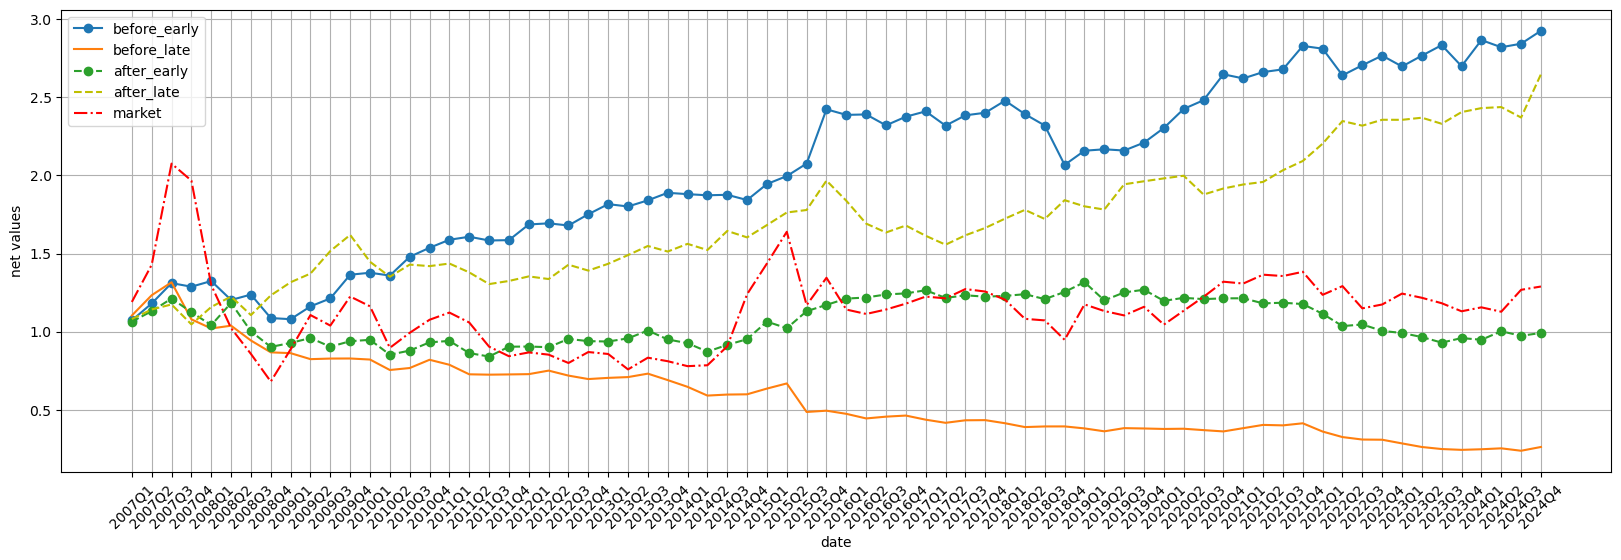

In [6]:
plt.figure(figsize=(20, 6))

# 创建折线图


plt.plot(protfolio1['report_type'].astype(str), protfolio1['net_value'], linestyle='-', marker='o', label='before_early')
plt.plot(protfolio2['report_type'].astype(str), protfolio2['net_value'], linestyle='-', label='before_late')

plt.plot(protfolio3['report_type'].astype(str), protfolio3['net_value'], linestyle='--', marker='o', label='after_early')
plt.plot(protfolio4['report_type'].astype(str), protfolio4['net_value'], linestyle='--', label='after_late', color='y')

plt.plot(index_rets['quarter'].astype(str), index_rets['net_values'], linestyle='-.', label='market', color='red')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()

# 分层

In [5]:
start = -10
end = -1

group = protfolio.loc[(protfolio['lag']==start)]
group = group.loc[(group['days_to_deadline']>0) & 
                          (group['is_suspended'] == False) &
                          (group['is_st'] == False) &
                          (group['trade_date'] >= (group['listed_date'] + datetime.timedelta(days=365)))] 
group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values

group_end = protfolio.loc[(protfolio['lag']==end), ['stock_symbol', 'report_type', 'trade_date', 'close']]

group = pd.merge(left=group[['stock_symbol', 'report_type', 'trade_date', 'close', 'group']], right=group_end, on=['stock_symbol', 'report_type'], how='left')

group = group.groupby(['report_type', 'group'])[['close_x', 'close_y']].mean().reset_index()
group['rets'] = group['close_y'] / group['close_x']
group['net_value'] = group.groupby('group')['rets'].cumprod()
group

C:\Users\plucky\AppData\Local\Temp\ipykernel_18324\1631749482.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values


,report_type,group,close_x,close_y,rets,net_value
0,20061231,0,5.464280,6.176091,1.130266,1.130266
1,20061231,1,5.300597,5.668056,1.069324,1.069324
2,20061231,2,4.400746,4.741912,1.077524,1.077524
3,20061231,3,3.953223,4.121438,1.042551,1.042551
4,20061231,4,3.480312,3.856064,1.107965,1.107965
...,...,...,...,...,...,...
344,20240331,4,31.197500,31.317300,1.003840,4.429929
345,20240630,0,11.270000,NaN,NaN,NaN
346,20240630,2,23.485120,22.950500,0.977236,2.480465
347,20240630,3,22.184995,22.442045,1.011587,15.177950


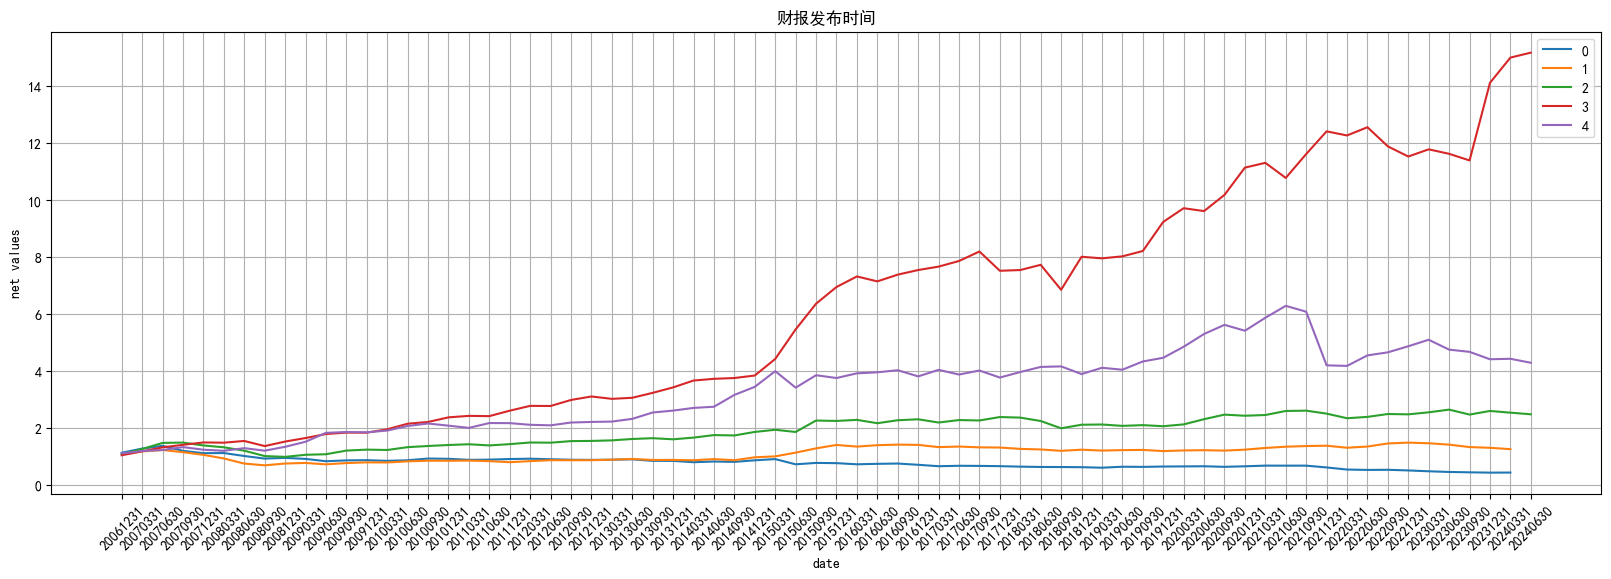

In [6]:
plt.figure(figsize=(20, 6))

# 创建折线图
plt.plot(group.loc[group['group']==0, 'report_type'], group.loc[group['group']==0, 'net_value'], linestyle='-', label='0')
plt.plot(group.loc[group['group']==1, 'report_type'], group.loc[group['group']==1, 'net_value'], linestyle='-', label='1')
plt.plot(group.loc[group['group']==2, 'report_type'], group.loc[group['group']==2, 'net_value'], linestyle='-', label='2')
plt.plot(group.loc[group['group']==3, 'report_type'], group.loc[group['group']==3, 'net_value'], linestyle='-', label='3')
plt.plot(group.loc[group['group']==4, 'report_type'], group.loc[group['group']==4, 'net_value'], linestyle='-', label='4')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('财报发布时间')
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()

In [7]:
start = 1
end = 10

group = protfolio.loc[(protfolio['lag']==start)]
group = group.loc[(group['days_to_deadline']>0) & 
                          (group['is_suspended'] == False) &
                          (group['is_st'] == False) &
                          (group['trade_date'] >= (group['listed_date'] + datetime.timedelta(days=365)))] 
group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values

group_end = protfolio.loc[(protfolio['lag']==end), ['stock_symbol', 'report_type', 'trade_date', 'close']]

group = pd.merge(left=group[['stock_symbol', 'report_type', 'trade_date', 'close', 'group']], right=group_end, on=['stock_symbol', 'report_type'], how='left')

group = group.groupby(['report_type', 'group'])[['close_x', 'close_y']].mean().reset_index()
group['rets'] = group['close_y'] / group['close_x']
group['net_value'] = group.groupby('group')['rets'].cumprod()
group

C:\Users\plucky\AppData\Local\Temp\ipykernel_18324\3435960061.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group['group'] = group.groupby('report_type').apply(lambda x: pd.cut(x['days_to_deadline'], bins=5, labels=False)).values


,report_type,group,close_x,close_y,rets,net_value
0,20061231,0,6.322699,7.133105,1.128174,1.128174
1,20061231,1,5.707498,6.330851,1.109217,1.109217
2,20061231,2,4.747809,5.101235,1.074440,1.074440
3,20061231,3,4.269155,4.432100,1.038168,1.038168
4,20061231,4,3.989585,4.192141,1.050771,1.050771
...,...,...,...,...,...,...
345,20240630,0,24.400000,NaN,NaN,NaN
346,20240630,1,23.473000,NaN,NaN,NaN
347,20240630,2,12.993333,NaN,NaN,NaN
348,20240630,3,7.680000,7.900000,1.028646,0.655128


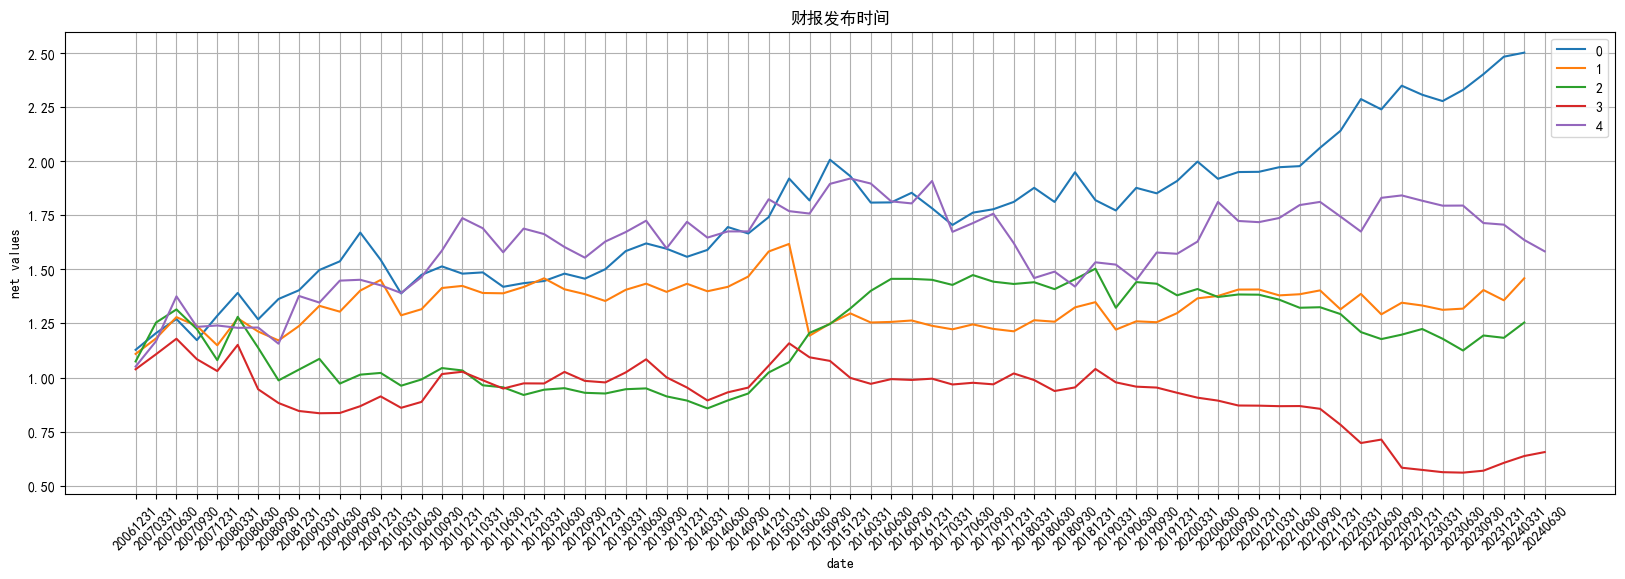

In [8]:
plt.figure(figsize=(20, 6))

# 创建折线图
plt.plot(group.loc[group['group']==0, 'report_type'], group.loc[group['group']==0, 'net_value'], linestyle='-', label='0')
plt.plot(group.loc[group['group']==1, 'report_type'], group.loc[group['group']==1, 'net_value'], linestyle='-', label='1')
plt.plot(group.loc[group['group']==2, 'report_type'], group.loc[group['group']==2, 'net_value'], linestyle='-', label='2')
plt.plot(group.loc[group['group']==3, 'report_type'], group.loc[group['group']==3, 'net_value'], linestyle='-', label='3')
plt.plot(group.loc[group['group']==4, 'report_type'], group.loc[group['group']==4, 'net_value'], linestyle='-', label='4')
# 旋转横坐标标签
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('财报发布时间')
plt.xlabel('date')
plt.ylabel('net values')

# 添加图例
plt.legend()

# 显示图表
plt.grid(True) 
plt.show()